In [207]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Data Preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor

# Time-Series Modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Feature Importance & Explainability
import shap
from pdpbox import pdp

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Deployment (if needed)
# from flask import Flask
# import fastapi
# import streamlit as st

# Warnings
import warnings
warnings.filterwarnings("ignore")

print("Updated libraries imported successfully!")


Updated libraries imported successfully!


### Step 1: Data Preparation

#### 1.1. Data Integrity

In [78]:
# Load datasets
stores_df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Retail Sales Prediction\stores data-set.csv")
features_df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Retail Sales Prediction\Features data set.csv")
sales_df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Retail Sales Prediction\sales data-set.csv")

# Display basic info about each dataset
print("Stores Dataset:")
print(stores_df.info(), "\n")

print("Features Dataset:")
print(features_df.info(), "\n")

print("Sales Dataset:")
print(sales_df.info(), "\n")

# Display first few rows of each dataset
print("Stores Sample:\n", stores_df.head(), "\n")
print("Features Sample:\n", features_df.head(), "\n")
print("Sales Sample:\n", sales_df.head(), "\n")

Stores Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None 

Features Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10 

#### 1.2. Convert Date to a proper datetime format for time-series analysis.

In [80]:
# Convert 'Date' column to datetime format with automatic detection
features_df['Date'] = pd.to_datetime(features_df['Date'], dayfirst=True, errors='coerce')
sales_df['Date'] = pd.to_datetime(sales_df['Date'], dayfirst=True, errors='coerce')

# Check if any dates failed to parse
print("Unparsed Dates in Features:", features_df[features_df['Date'].isna()])
print("Unparsed Dates in Sales:", sales_df[sales_df['Date'].isna()])


Unparsed Dates in Features: Empty DataFrame
Columns: [Store, Date, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, IsHoliday]
Index: []
Unparsed Dates in Sales: Empty DataFrame
Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
Index: []


#### 1.3. Handle Duplicates 

In [82]:
# Check for duplicates in each dataset
print("Duplicate rows in Stores dataset:", stores_df.duplicated().sum())
print("Duplicate rows in Features dataset:", features_df.duplicated(subset=['Store', 'Date']).sum())
print("Duplicate rows in Sales dataset:", sales_df.duplicated(subset=['Store', 'Dept', 'Date']).sum())

Duplicate rows in Stores dataset: 0
Duplicate rows in Features dataset: 0
Duplicate rows in Sales dataset: 0


#### 1.4. Handle Missing Values

In [84]:
# Check for missing values
print("Missing Values in Stores Dataset:\n", stores_df.isnull().sum(), "\n")
print("Missing Values in Features Dataset:\n", features_df.isnull().sum(), "\n")
print("Missing Values in Sales Dataset:\n", sales_df.isnull().sum(), "\n")

Missing Values in Stores Dataset:
 Store    0
Type     0
Size     0
dtype: int64 

Missing Values in Features Dataset:
 Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64 

Missing Values in Sales Dataset:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64 



In [86]:
# Fill missing MarkDown values with 0 (no markdown)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
features_df[markdown_cols] = features_df[markdown_cols].fillna(0)

# Fill missing CPI and Unemployment with rolling mean per store
features_df['CPI'] = features_df.groupby('Store')['CPI'].transform(lambda x: x.fillna(x.rolling(5, min_periods=1).mean()))
features_df['Unemployment'] = features_df.groupby('Store')['Unemployment'].transform(lambda x: x.fillna(x.rolling(5, min_periods=1).mean()))

# Check if any missing values remain
print("Remaining missing values in Features dataset:\n", features_df.isnull().sum())


Remaining missing values in Features dataset:
 Store             0
Date              0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI             405
Unemployment    405
IsHoliday         0
dtype: int64


##### CPI and Unemployment are economic indicators that change gradually over time, we will:
##### First, use forward fill (ffill) to propagate the last known value.
##### Then, use backward fill (bfill) to ensure that even initial missing values are fille

In [88]:
# Forward fill first (fill missing values using the last known value)
features_df['CPI'] = features_df.groupby('Store')['CPI'].ffill()
features_df['Unemployment'] = features_df.groupby('Store')['Unemployment'].ffill()

# Backward fill to fill remaining missing values
features_df['CPI'] = features_df.groupby('Store')['CPI'].bfill()
features_df['Unemployment'] = features_df.groupby('Store')['Unemployment'].bfill()

# Final check for missing values
print("Final missing values in Features dataset:\n", features_df.isnull().sum())


Final missing values in Features dataset:
 Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64


#### 1.5. Handle Outliers

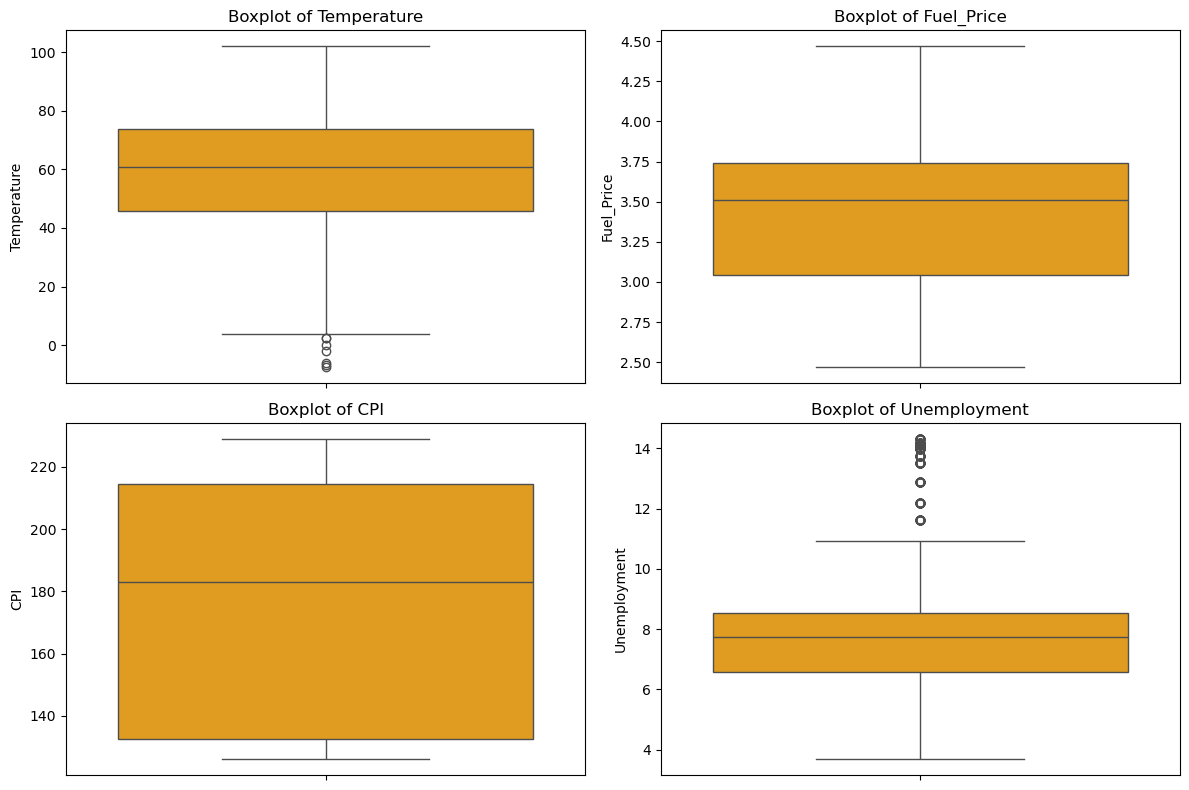

In [90]:
# Define numerical columns for outlier visualization (excluding Weekly_Sales)
num_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create boxplots for each numerical column
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=features_df[col], color="orange")
    plt.title(f'Boxplot of {col}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [102]:
from scipy.stats.mstats import winsorize

# Apply Winsorization to cap extreme outliers (1st and 99th percentile)
features_df['Temperature'] = winsorize(features_df['Temperature'], limits=[0.01, 0.01])  # Capping 1% low & high values
features_df['Unemployment'] = winsorize(features_df['Unemployment'], limits=[0.03, 0.03])  # Capping 3% high values

print("Outliers in Temperature and Unemployment capped using Winsorization.")


Outliers in Temperature and Unemployment capped using Winsorization.


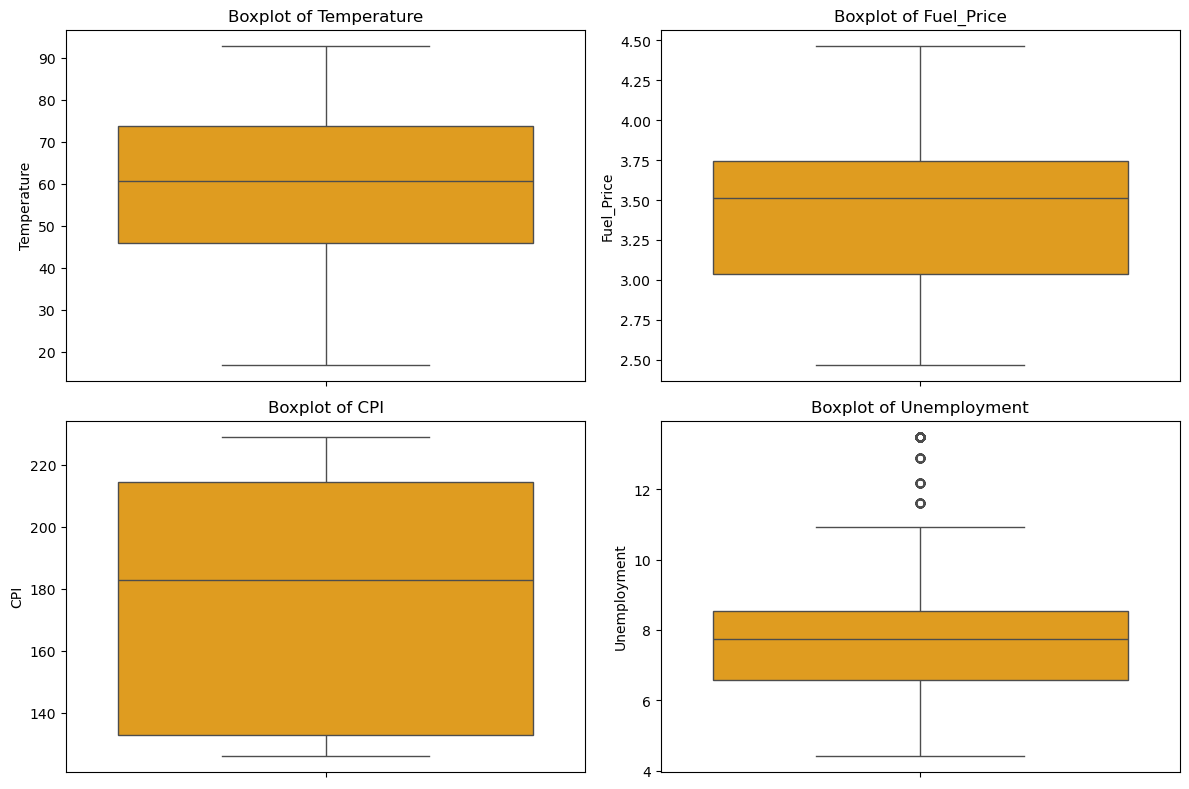

In [106]:
# Define numerical columns for outlier visualization (excluding Weekly_Sales)
num_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create boxplots for each numerical column
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=features_df[col], color="orange")
    plt.title(f'Boxplot of {col}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### Step 2: Feature Engineering

#### 2.1. Handle Time-Based Features
##### Since sales are highly seasonal, we extract time components:
#####  - Year, Month, Week of Year, Day of the Week
#####  - IsWeekend (0 for weekdays, 1 for Sat/Sun)

In [112]:
# Extract time features
sales_df['Year'] = sales_df['Date'].dt.year
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Week'] = sales_df['Date'].dt.isocalendar().week
sales_df['DayOfWeek'] = sales_df['Date'].dt.weekday  # Monday = 0, Sunday = 6

# Create a binary weekend feature (0=Weekday, 1=Weekend)
sales_df['IsWeekend'] = sales_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

print("Time-based features added.")


Time-based features added.


#### 2.2. Lag Features (Sales History)
##### Retail sales depend on past values, let's introduce lagged sales features:
#####  - Previous Week’s Sales (Lag_1)
#####  - 4-Week Rolling Average (Rolling_4)
#####  - 12-Week Rolling Average (Rolling_12)
#####  - Same Week Last Year (Lag_52)

In [115]:
# Sort data before creating lag features
sales_df = sales_df.sort_values(by=['Store', 'Dept', 'Date'])

# Create lag features
sales_df['Lag_1'] = sales_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
sales_df['Rolling_4'] = sales_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(4, min_periods=1).mean())
sales_df['Rolling_12'] = sales_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(12, min_periods=1).mean())
sales_df['Lag_52'] = sales_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)

print("Lagged sales features added.")


Lagged sales features added.


#### 2.3. Holiday Impact Features
##### The dataset already has an IsHoliday flag, but we will enhance it by:
#####  - Let's create specific holiday indicators (e.g., SuperBowl, Thanksgiving, Christmas)

In [120]:
# Define holiday dates
holiday_dates = {
    "SuperBowl": ['2010-02-12', '2011-02-11', '2012-02-10'],
    "LaborDay": ['2010-09-10', '2011-09-09', '2012-09-07'],
    "Thanksgiving": ['2010-11-26', '2011-11-25', '2012-11-23'],
    "Christmas": ['2010-12-31', '2011-12-30', '2012-12-28']
}

# Convert to datetime and create new holiday columns
for holiday, dates in holiday_dates.items():
    sales_df[holiday] = sales_df['Date'].isin(pd.to_datetime(dates)).astype(int)

print("Holiday features added.")


Holiday features added.


#### 2.4. Markdown Impact on Sales

##### Since markdowns (discounts) influence sales, we create:
##### Interaction Feature (MarkDown * IsHoliday) to check markdown effect on holiday weeks

In [126]:
# Create total markdown feature
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
features_df['Total_MarkDown'] = features_df[markdown_cols].sum(axis=1)

# Create interaction feature (Markdown during holiday weeks)
features_df['MarkDown_Holiday'] = features_df['Total_MarkDown'] * features_df['IsHoliday']

print("Markdown impact features added.")


Markdown impact features added.


#### 2.5. Merging Datasets

In [136]:
# Step 1: Merge Sales and Features on Store & Date
merged_df = sales_df.merge(features_df, on=['Store', 'Date'], how='left')

# Step 2: Merge with Stores dataset on Store
merged_df = merged_df.merge(stores_df, on='Store', how='left')

# Final Check: Display merged dataset structure
print("Final Merged Dataset Structure:\n", merged_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             421570 non-null  int64         
 1   Dept              421570 non-null  int64         
 2   Date              421570 non-null  datetime64[ns]
 3   Weekly_Sales      421570 non-null  float64       
 4   IsHoliday_x       421570 non-null  bool          
 5   Year              421570 non-null  int32         
 6   Month             421570 non-null  int32         
 7   Week              421570 non-null  UInt32        
 8   DayOfWeek         421570 non-null  int32         
 9   IsWeekend         421570 non-null  int64         
 10  Lag_1             418239 non-null  float64       
 11  Rolling_4         421570 non-null  float64       
 12  Rolling_12        421570 non-null  float64       
 13  Lag_52            261083 non-null  float64       
 14  Supe

In [138]:
# Check for any remaining missing values
print("\nMissing Values in Merged Dataset:\n", merged_df.isnull().sum())


Missing Values in Merged Dataset:
 Store                    0
Dept                     0
Date                     0
Weekly_Sales             0
IsHoliday_x              0
Year                     0
Month                    0
Week                     0
DayOfWeek                0
IsWeekend                0
Lag_1                 3331
Rolling_4                0
Rolling_12               0
Lag_52              160487
SuperBowl                0
LaborDay                 0
Thanksgiving             0
Christmas                0
Temperature              0
Fuel_Price               0
MarkDown1                0
MarkDown2                0
MarkDown3                0
MarkDown4                0
MarkDown5                0
CPI                      0
Unemployment             0
IsHoliday_y              0
Total_MarkDown           0
MarkDown_Holiday         0
Type                     0
Size                     0
dtype: int64


In [140]:
# Fill Lag_1 with the median Weekly_Sales per Store-Dept
merged_df['Lag_1'] = merged_df.groupby(['Store', 'Dept'])['Lag_1'].transform(lambda x: x.fillna(x.median()))

# Fill Lag_52 with the median Weekly_Sales per Store-Dept
merged_df['Lag_52'] = merged_df.groupby(['Store', 'Dept'])['Lag_52'].transform(lambda x: x.fillna(x.median()))

# Verify missing values are handled
print("\nMissing Values After Filling:\n", merged_df.isnull().sum())



Missing Values After Filling:
 Store                  0
Dept                   0
Date                   0
Weekly_Sales           0
IsHoliday_x            0
Year                   0
Month                  0
Week                   0
DayOfWeek              0
IsWeekend              0
Lag_1                 37
Rolling_4              0
Rolling_12             0
Lag_52              5059
SuperBowl              0
LaborDay               0
Thanksgiving           0
Christmas              0
Temperature            0
Fuel_Price             0
MarkDown1              0
MarkDown2              0
MarkDown3              0
MarkDown4              0
MarkDown5              0
CPI                    0
Unemployment           0
IsHoliday_y            0
Total_MarkDown         0
MarkDown_Holiday       0
Type                   0
Size                   0
dtype: int64


In [142]:
# Fill remaining missing Lag_1 with overall median
merged_df['Lag_1'].fillna(merged_df['Lag_1'].median(), inplace=True)

# Fill remaining missing Lag_52 with overall median
merged_df['Lag_52'].fillna(merged_df['Lag_52'].median(), inplace=True)

# Verify all missing values are handled
print("\nFinal Missing Values After Filling:\n", merged_df.isnull().sum())



Final Missing Values After Filling:
 Store               0
Dept                0
Date                0
Weekly_Sales        0
IsHoliday_x         0
Year                0
Month               0
Week                0
DayOfWeek           0
IsWeekend           0
Lag_1               0
Rolling_4           0
Rolling_12          0
Lag_52              0
SuperBowl           0
LaborDay            0
Thanksgiving        0
Christmas           0
Temperature         0
Fuel_Price          0
MarkDown1           0
MarkDown2           0
MarkDown3           0
MarkDown4           0
MarkDown5           0
CPI                 0
Unemployment        0
IsHoliday_y         0
Total_MarkDown      0
MarkDown_Holiday    0
Type                0
Size                0
dtype: int64


#### 2.6. Let's separate the target variable - Weekly_Sales

In [146]:
# Define target variable
y = merged_df['Weekly_Sales']

# Define independent variables (remove target)
X = merged_df.drop(columns=['Weekly_Sales'])

# Verify separation
print("Target Variable Separated!")
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)


Target Variable Separated!
Shape of X (features): (421570, 31)
Shape of y (target): (421570,)


#### 2.7. Let's identiy Numerical and categorical variables

In [151]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print feature categories
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['Type']
Numerical Features: ['Store', 'Dept', 'IsWeekend', 'Lag_1', 'Rolling_4', 'Rolling_12', 'Lag_52', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Total_MarkDown', 'MarkDown_Holiday', 'Size']


In [153]:
# One-Hot Encode 'Type' feature
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

# Verify encoding
print("Categorical Features Encoded Successfully!")
print("Updated Feature Columns:", X.columns)


Categorical Features Encoded Successfully!
Updated Feature Columns: Index(['Store', 'Dept', 'Date', 'IsHoliday_x', 'Year', 'Month', 'Week',
       'DayOfWeek', 'IsWeekend', 'Lag_1', 'Rolling_4', 'Rolling_12', 'Lag_52',
       'SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Total_MarkDown',
       'MarkDown_Holiday', 'Size', 'Type_B', 'Type_C'],
      dtype='object')


#### Correlation Matrix

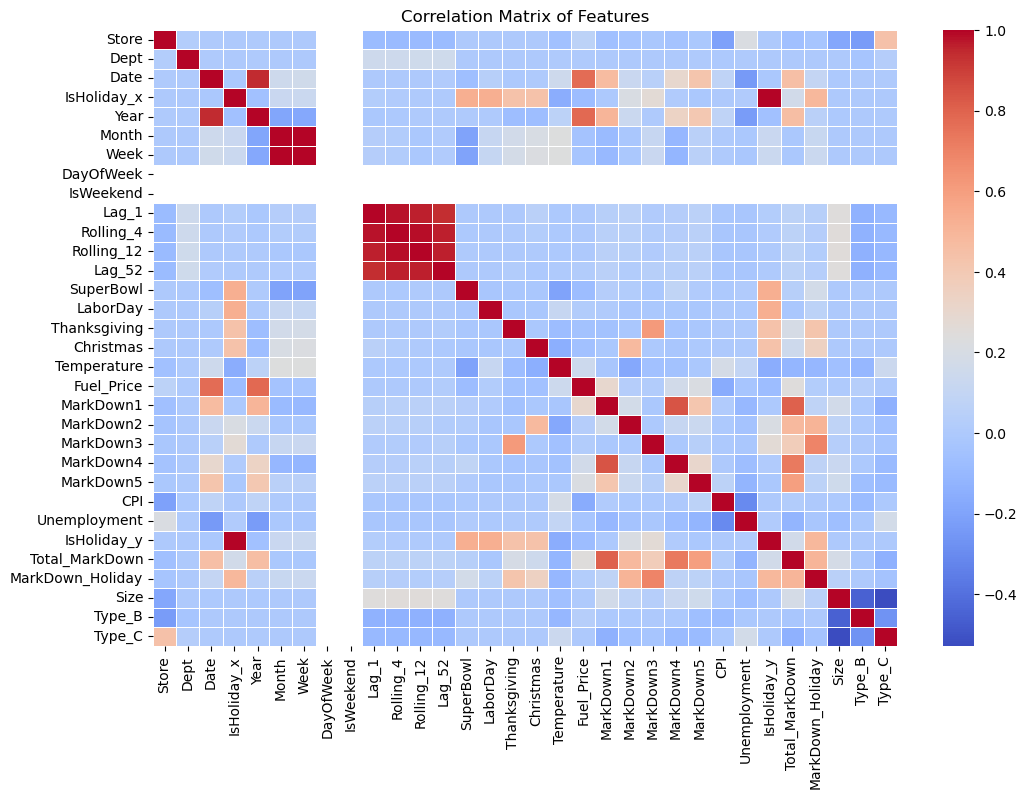

In [156]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

# Set title
plt.title("Correlation Matrix of Features")

# Show plot
plt.show()

### Step 3: Data Preprocessing

#### 3.1. Feature Importance

In [162]:
# Check if X contains any datetime columns
datetime_cols = X.select_dtypes(include=['datetime']).columns.tolist()
print("Datetime Columns in X:", datetime_cols)


Datetime Columns in X: ['Date']


In [164]:
# Drop 'Date' column if it exists
if 'Date' in X.columns:
    X = X.drop(columns=['Date'])

print("Datetime columns removed. Ready for feature importance analysis!")


Datetime columns removed. Ready for feature importance analysis!


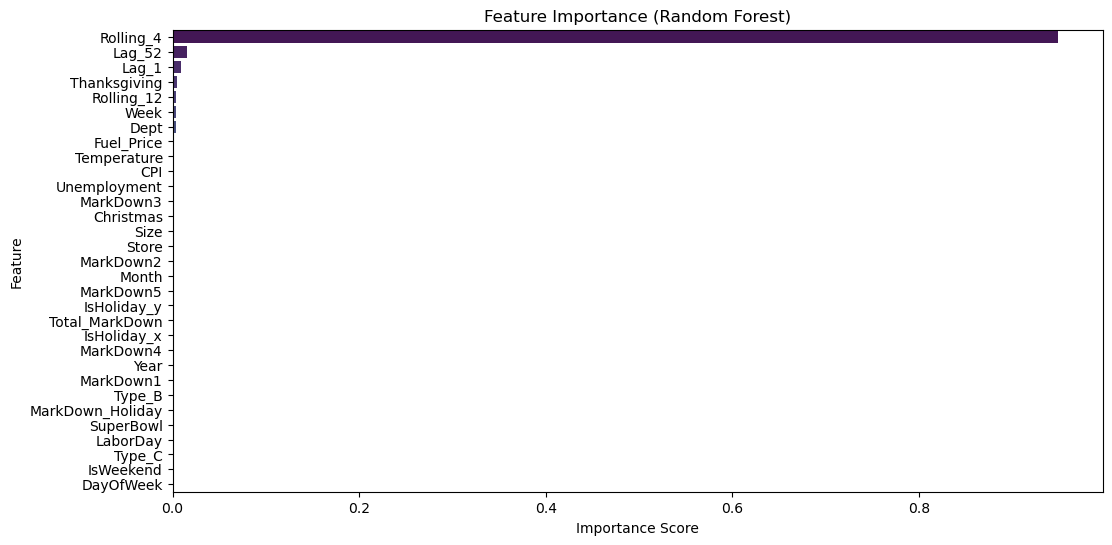

In [168]:
# Train a RandomForestRegressor for feature importance analysis

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [170]:
# Display feature importance table
print("Feature Importance Table:")
print(feature_importance_df)

Feature Importance Table:
             Feature  Importance
9          Rolling_4    0.949083
11            Lag_52    0.015670
8              Lag_1    0.009107
14      Thanksgiving    0.004782
10        Rolling_12    0.004191
5               Week    0.003978
1               Dept    0.003517
17        Fuel_Price    0.001197
16       Temperature    0.001080
23               CPI    0.000951
24      Unemployment    0.000923
20         MarkDown3    0.000747
15         Christmas    0.000704
28              Size    0.000695
0              Store    0.000585
19         MarkDown2    0.000527
4              Month    0.000390
22         MarkDown5    0.000274
25       IsHoliday_y    0.000268
26    Total_MarkDown    0.000227
2        IsHoliday_x    0.000219
21         MarkDown4    0.000212
3               Year    0.000202
18         MarkDown1    0.000201
29            Type_B    0.000099
27  MarkDown_Holiday    0.000096
12         SuperBowl    0.000031
13          LaborDay    0.000027
30            Typ

##### Drop Features

In [173]:
# Define features to drop
features_to_drop = [
    'IsWeekend', 'DayOfWeek', 'MarkDown_Holiday', 'SuperBowl', 'LaborDay', 'Type_C', 'Year',
    'Lag_1', 'Lag_52', 'IsHoliday_x',  # Keeping only IsHoliday_y
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'
]

# Drop selected features
X = X.drop(columns=features_to_drop)

# Confirm new feature set
print("Updated feature set after removing less important and correlated features:")
print(X.columns)


Updated feature set after removing less important and correlated features:
Index(['Store', 'Dept', 'Month', 'Week', 'Rolling_4', 'Rolling_12',
       'Thanksgiving', 'Christmas', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday_y', 'Total_MarkDown', 'Size', 'Type_B'],
      dtype='object')


In [177]:
# Identify numerical and categorical features
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display identified features
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['IsHoliday_y', 'Type_B']
Numerical Features: ['Store', 'Dept', 'Rolling_4', 'Rolling_12', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown', 'Size']


In [181]:
from sklearn.preprocessing import StandardScaler

# List of numerical features to scale
numerical_cols = ['Store', 'Dept', 'Rolling_4', 'Rolling_12', 'Temperature', 
                  'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown', 'Size']

# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Confirm scaling success
print("Numerical features scaled successfully!")


Numerical features scaled successfully!


In [183]:
# Ensure 'Date' column exists in merged_df
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Define training and testing periods
train_period = merged_df['Date'] < '2012-01-01'  # Train on data before 2012
test_period = merged_df['Date'] >= '2012-01-01'  # Test on data from 2012 onward

# Perform time-based split
X_train = X[train_period]
y_train = y[train_period]
X_test = X[test_period]
y_test = y[test_period]

# Confirm split success
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)


Training Set Shape: (294132, 16) (294132,)
Test Set Shape: (127438, 16) (127438,)


##### Handle Imbalance

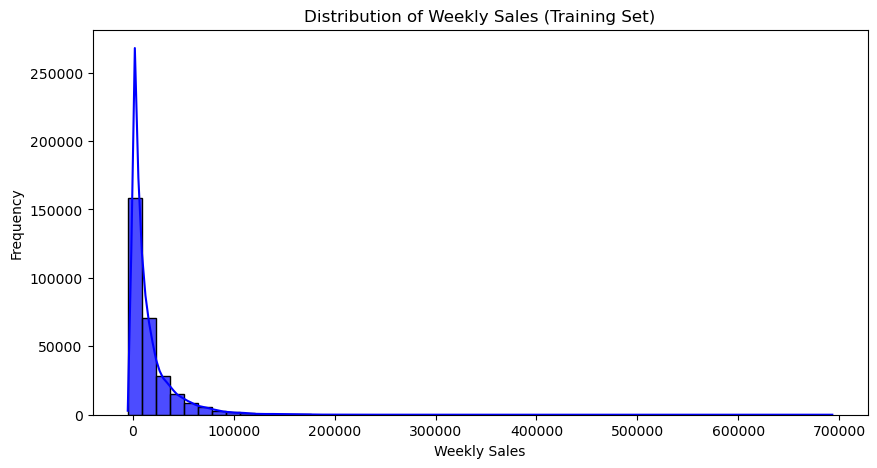

Target Variable (Weekly_Sales) Statistics:
count    294132.000000
mean      16105.306895
std       22961.301005
min       -4988.940000
25%        2146.025000
50%        7727.310000
75%       20356.665000
max      693099.360000
Name: Weekly_Sales, dtype: float64


In [185]:
plt.figure(figsize=(10, 5))

# Plot distribution of target variable in training set
sns.histplot(y_train, bins=50, kde=True, color='blue', alpha=0.7)

# Set title and labels
plt.title("Distribution of Weekly Sales (Training Set)")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")

# Show plot
plt.show()

# Print basic statistics
print("Target Variable (Weekly_Sales) Statistics:")
print(y_train.describe())

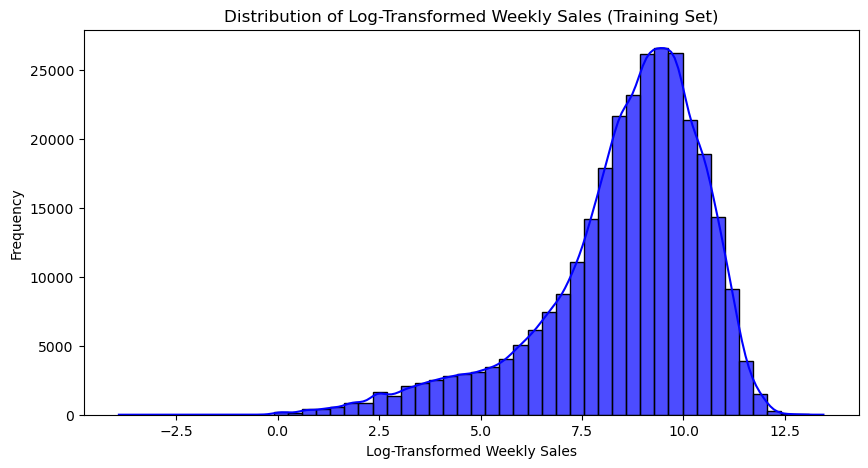

In [187]:
# Apply log transformation to y_train and y_test
y_train_log = np.log1p(y_train)  # log(1 + y) to avoid log(0)
y_test_log = np.log1p(y_test)

# Confirm transformation success with new distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(y_train_log, bins=50, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Log-Transformed Weekly Sales (Training Set)")
plt.xlabel("Log-Transformed Weekly Sales")
plt.ylabel("Frequency")
plt.show()

In [190]:
# Assign sample weights: 5x for holiday weeks, 1x for non-holiday weeks
sample_weights_train = y_train.copy()
sample_weights_train[merged_df.loc[train_period, 'IsHoliday_y'] == 1] = 5  # Increase weight for holidays
sample_weights_train[merged_df.loc[train_period, 'IsHoliday_y'] == 0] = 1  # Normal weight for others

# Assign sample weights for the test set (not used in training, only for evaluation)
sample_weights_test = y_test.copy()
sample_weights_test[merged_df.loc[test_period, 'IsHoliday_y'] == 1] = 5
sample_weights_test[merged_df.loc[test_period, 'IsHoliday_y'] == 0] = 1

print("✅ Sample weights assigned!")


✅ Sample weights assigned!


In [196]:
# Replace negative sales with a small positive value (or drop them)
y_train_fixed = y_train.copy()
y_train_fixed[y_train_fixed < 0] = 1  # Avoid log(0) issues

y_test_fixed = y_test.copy()
y_test_fixed[y_test_fixed < 0] = 1  # Avoid log(0) issues

# Apply log transformation
y_train_log = np.log1p(y_train_fixed)  # log(1 + y)
y_test_log = np.log1p(y_test_fixed)

print("✅ Log transformation applied successfully after fixing negative sales!")

✅ Log transformation applied successfully after fixing negative sales!


In [198]:
from sklearn.ensemble import RandomForestRegressor

# Train model with log-transformed sales & weights
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_log, sample_weight=sample_weights_train)

print("✅ Random Forest Model trained with weighted loss!")


✅ Random Forest Model trained with weighted loss!


In [202]:
from xgboost import XGBRegressor

# Train XGBoost with log-transformed sales & weights
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train_log, sample_weight=sample_weights_train)

print("✅ XGBoost Model trained with weighted loss!")


✅ XGBoost Model trained with weighted loss!


In [204]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test_log, sample_weights, model_name):
    y_pred_log = model.predict(X_test)  # Predict in log scale
    y_pred = np.expm1(y_pred_log)  # Convert back to original scale

    y_true = np.expm1(y_test_log)  # Convert true values back to original scale

    mae = mean_absolute_error(y_true, y_pred, sample_weight=sample_weights)
    mse = mean_squared_error(y_true, y_pred, sample_weight=sample_weights)
    r2 = r2_score(y_true, y_pred)

    print(f"\n🔹 {model_name} Performance (Weighted & Log-Transformed):")
    print(f"📌 MAE: {mae:.4f}")
    print(f"📌 MSE: {mse:.4f}")
    print(f"📌 R² Score: {r2:.4f}")

# Evaluate both models
evaluate_model(rf_model, X_test, y_test_log, sample_weights_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test_log, sample_weights_test, "XGBoost")


🔹 Random Forest Performance (Weighted & Log-Transformed):
📌 MAE: 1391.3622
📌 MSE: 9862814.7850
📌 R² Score: 0.9817

🔹 XGBoost Performance (Weighted & Log-Transformed):
📌 MAE: 1364.6126
📌 MSE: 9202018.6068
📌 R² Score: 0.9821
